In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter  
drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'

In [15]:
cell_types = []
sign_map = {'FS':'exc', 'RS':'inh'}
cell_idxs = np.arange(len(cell_table))
for c_idx in cell_idxs:#[-k:]:
    c_type = ''
    c_type += sign_map[cell_table.RSFS.values[c_idx]] + '_'
    c_type += cell_table.structure.values[c_idx] + '_'
    if str.startswith(cell_table.structure.values[c_idx],'VIS'):
        if cell_table.depth.values[c_idx] > -920:
            c_type += '1'
        elif cell_table.depth.values[c_idx] > -960:
            c_type += '4'
        else:
            c_type += '5'
    cell_types.append(c_type)
print len(cell_types), np.unique(cell_types)

np.savez('cell_types71',cell_types=cell_types)

71 ['exc_VISp_1' 'exc_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_5']


In [2]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Add,add, Maximum, Layer, Dense, Lambda
from keras import Sequential
from keras.regularizers import Regularizer
from keras.callbacks import LearningRateScheduler
from scipy.special import gamma
from scipy.stats import pearsonr
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
D = np.load('drifting_gratings_data.npz')
binned_spikes = D['binned_spikes']
stim = D['stim_array']
CCmaxs = D['CCmaxs']
bin_len = 0.01
D = np.load('cell_types71.npz')
cell_types = D['cell_types']

ord_idxs = np.argsort(CCmaxs)[-30:]
ord_idxs = np.concatenate((ord_idxs[:-12],ord_idxs[-11:-6],ord_idxs[-4:])) #these particular cells caused problems
print CCmaxs[ord_idxs[-1]]

0.9199474554408273


In [4]:
d = 30
conds = np.unique(stim,axis=1)  
mod_stim = np.zeros((conds.shape[1],stim.shape[1]))
for t in range(stim.shape[1]):
    ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
    mod_stim[ind,t] = 1

[]


In [43]:
# st = np.concatenate((np.zeros((mod_stim.shape[0],1)),np.diff(mod_stim,axis=1)),axis=1)>0
# print st.shape, binned_spikes.shape

conds = np.unique(stim,axis=1)  
mod_stim2 = np.zeros((7*(conds.shape[1]-1),stim.shape[1]))
ind_old = -1
for t in range(stim.shape[1]):
    if stim[0,t]>0:
        ind = np.argwhere(np.all(stim[:,t:t+1]-conds==0,axis=0))
        if ind!=ind_old:
            t0=t
            ind_old=ind
        mod_stim2[(ind-1)*3,t] = np.cos(2.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*3+1,t] = np.sin(2.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*3+2,t] = np.cos(4.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*3+3,t] = np.sin(4.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*3+4,t] = np.cos(6.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*3+5,t] = np.sin(6.0*np.pi*stim[0,t]*(t-t0)*bin_len)
        mod_stim2[(ind-1)*3+6,t] = 1
    else:
        ind_old = -1

In [45]:
# individual parameter sets

def batch_generator(flat_stimulus, binned_spikes, inds, d, batch_size=5000):
    d1,d2 = d
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    T = inds.size
    k=0
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[inds[idxs]]
        X = np.empty((M*d1+d2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d1:inds[idx]],[1,-1]))
            X[M*d1:,i] = np.fliplr(np.reshape(binned_spikes[inds[idx]-d2:inds[idx]],[1,-1]))
        k = k+batch_size
        if k>T:
            k=0
        yield X.T, y

        
        
def exp_decay(t):
    initial_lrate = 2e-2
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate

def corrcoef(x,y):
    xmean = np.mean(x)
    ymean = np.mean(x)
    cov = np.mean((x-xmean)*(y-ymean))
    return cov/(np.std(x)*np.std(y))

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None,frac_train=0.75):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    
#     train_end_ind = 280000 #3*T/4-10*d
#     val_start_ind = 280000 #3*T/4+10*d

    bs = 3000
    dmax = max(d)
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    F = np.empty((N,M,d[0])) # stimulus filters
    W = np.empty((N,d[1]))  # spike train filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),1+int(2200/bin_len))))+dmax
    val_inds = np.arange(int(3200/bin_len),T)+dmax
        
    for i in range(N):
        print i
        smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
        
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d[0]+d[1],use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator(stimulus,spikes[i,:],train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = train_inds.size/bs+1,
                            epochs=15,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        val_gen = batch_generator(stimulus,spikes[i,:],val_inds, d,batch_size=bs)
#         all_gen = batch_generator(stimulus,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = bs)
#         pred = model.predict_generator(all_gen,steps=T/bs).squeeze()
#         plt.plot(smoothed_spikes[i,train_inds],pred[train_inds-d[1]],'b,')
#         plt.plot(smoothed_spikes[i,val_inds],pred[val_inds-d[1]],'r,')
#         plt.plot(spikes[i,:200])
#         plt.plot(smoothed_spikes[:200])
#         plt.plot(pred[:200])
        
###
#         p = model.get_weights()[0]
#         F[i,:,:] = p[:M*d[0]].reshape((M,d[0]))
#         W[i,:] = np.squeeze(p[M*d[0]:])
#         b[i] = model.get_weights()[1]
#         train_pred = model.predict_generator(train_gen,steps=train_inds.size/bs+1).squeeze()
#         train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs+1)
#         train_corrs[i] = pearsonr(smoothed_spikes[train_inds],train_pred)[0]
#         val_losses[i] = model.evaluate_generator(val_gen,steps=val_inds.size/bs+1)
#         val_pred = model.predict_generator(val_gen,steps=val_inds.size/bs+1).squeeze()
#         val_corrs[i] = pearsonr(smoothed_spikes[val_inds],val_pred)[0]
###       
        
        all_gen = batch_generator(stimulus,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = T)
        pred = model.predict_generator(all_gen,steps=2).squeeze()
        p = model.get_weights()[0]
        F[i,:,:] = p[:M*d[0]].reshape((M,d[0]))
        W[i,:] = np.squeeze(p[M*d[0]:])
        b[i] = model.get_weights()[1]
        train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs)
        train_corrs[i] = pearsonr(smoothed_spikes[train_inds],pred[train_inds-dmax])[0]
        val_losses[i] = model.evaluate_generator(val_gen,steps=1)
        val_corrs[i] = pearsonr(smoothed_spikes[val_inds],pred[val_inds-dmax])[0]
        
        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [46]:
d=[1,30]
# d = [int(2/bin_len),30]

(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit(mod_stim2,binned_spikes[ord_idxs,:],d, bin_len)


0
Epoch 1/15
 - 5s - loss: 0.7166
Epoch 2/15
 - 2s - loss: 0.6127
Epoch 3/15
 - 2s - loss: 0.5997
Epoch 4/15
 - 2s - loss: 0.5862
Epoch 5/15
 - 2s - loss: 0.5766
Epoch 6/15
 - 2s - loss: 0.5697
Epoch 7/15
 - 2s - loss: 0.5649
Epoch 8/15
 - 2s - loss: 0.5614
Epoch 9/15
 - 2s - loss: 0.5590
Epoch 10/15
 - 2s - loss: 0.5574
Epoch 11/15


KeyboardInterrupt: 

In [41]:
np.savez('drifting_gratings_indivfit4',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs,W=W,F=F)


(-1.4500000000000002, 30.45, -0.14482984840869903, 0.5439508348703385)

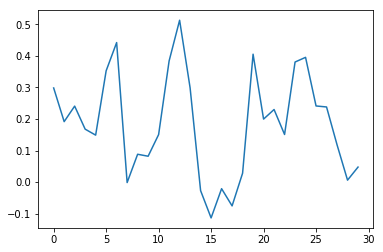

In [233]:
plt.plot(W.squeeze())
plt.axis('tight')

(-0.5, 7.5, 4.5, -0.5)

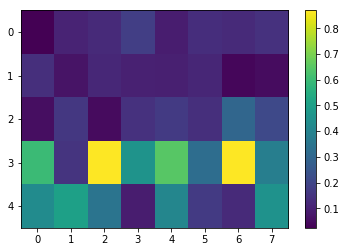

In [241]:
plt.imshow(np.sqrt(F.squeeze()[4::7]**2+F.squeeze()[5::7]**2).reshape(5,8))#,cmap='PiYG',vmin=-0.2,vmax=0.2)
# plt.imshow(F.squeeze()[6::7].reshape(5,8),cmap='PiYG',vmin=-0.2,vmax=0.2)
plt.colorbar()
plt.axis('tight')

22


(-0.05, 1.1026138238309307, -0.10022228638407024, 1.0523915374468604)

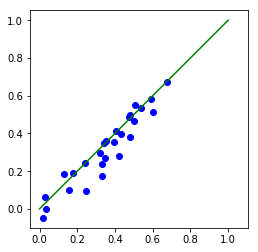

In [40]:
D = np.load('drifting_gratings_indivfit3.npz')
print np.argmax(val_corrs)
lims = [0,1]
plt.plot(train_corrs,val_corrs,'bo',lims,lims,'g')
# plt.plot(D['train_corrs'],train_corrs,'bo',lims,lims,'g')
plt.axis('square')

In [49]:
#parameter sets shared across predefined classes

def batch_generator_shared(flat_stimulus, binned_spikes,inds, d,neuron=None, batch_size=5000):
    (M,_) = flat_stimulus.shape # M is the size of a stimulus
    (N,_) = binned_spikes.shape
    T = inds.size
    d1,d2 = d
    if len(binned_spikes.shape)==1:
        binned_spikes = np.expand_dims(binned_spikes,0)
    k=0
    if neuron is None:
        neur = 0
    else:
        neur = neuron
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[neur,inds[idxs]]
        X = np.empty((M*d1+d2+2,idxs.size))
        for i,idx in enumerate(idxs):
            X[:M*d1,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d1:inds[idx]],[1,-1]))
            X[M*d1,i] = 1
            X[M*d1+1:-1,i] = np.fliplr(np.reshape(binned_spikes[neur,inds[idx]-d2:inds[idx]],[1,-1]))
            X[-1,i] = neur
        k = k+batch_size
        if k>T:
            k=0
            if neuron is None:
                neur+=1
                if neur==N:
                    neur = 0
        yield X.T, y


class GatedDense(Layer):

    def __init__(self, neuron, output_dim, **kwargs):
        self.neuron = neuron
        self.output_dim = output_dim
        super(GatedDense, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.output_dim, 1), initializer='glorot_uniform',
                                      trainable=True)
        super(GatedDense, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.expand_dims(K.switch(K.equal(float(self.neuron),x[:,-1]),K.squeeze(K.dot(x[:,:self.output_dim],self.kernel),1),K.zeros_like(x[:,-1])))


    def compute_output_shape(self, input_shape):
        return (input_shape[0],1)

def exp_decay(t):
    initial_lrate = 3e-3
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate


# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_shared_fit(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None,frac_train=0.75):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
#     train_end_ind = 280000 # 3*T/4-10*d
#     val_start_ind = 280000 # 3*T/4+10*d
    bs = 2000
    
    dmax = max(d)
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),1+int(2200/bin_len))))+dmax
    val_inds = np.arange(int(3200/bin_len),T)+dmax
    
    classes = np.unique(cell_types)
    
    F = np.empty((N,M,d[0])) # stimulus filters
    W = {}
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for cls in classes:
        
        # construct GLM model and return fit
        cls_idxs = np.squeeze(np.argwhere(cell_types==cls))
        cls_spikes = spikes[cls_idxs,:]
        print cls, cls_idxs.size
        inp = Input(shape = (M*d[0]+d[1]+2,))
        x = []
        for idx in range(cls_idxs.size):
            x.append(GatedDense(idx,M*d[0]+1)(inp))
        a = Lambda(lambda val: val[:,M*d[0]+1:-1])(inp)
        x.append(Dense(1,use_bias=False)(a))
        x = Add()(x)
        out = Lambda(lambda val: fs[f](val)*bin_len)(x)
        model = Model(inputs=[inp],outputs=[out])
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator_shared(stimulus,cls_spikes,train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = (train_inds.size/bs+1)*cls_idxs.size,
                            epochs=15,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        p = model.get_weights()
        for idx,i in enumerate(cls_idxs):
            smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
            F[i,:,:] = p[idx][:-1].reshape((M,d[0]))
            b[i] = p[idx][-1]
            train_gen = batch_generator_shared(stimulus,cls_spikes,train_inds, d, neuron = idx,batch_size=train_inds.size)
            train_losses[i] = model.evaluate_generator(train_gen,steps=1)
            train_corrs[i] = pearsonr(smoothed_spikes[train_inds],model.predict_generator(train_gen,steps=2).squeeze())[0]
            val_gen = batch_generator_shared(stimulus,cls_spikes,val_inds, d, neuron = idx, batch_size=val_inds.size)
            val_losses[i] = model.evaluate_generator(val_gen,steps=1)
            val_corrs[i] = pearsonr(smoothed_spikes[val_inds],model.predict_generator(val_gen,steps=2).squeeze())[0]
        W[cls] = p[-1]

        models.append(model)
    return (F,W,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [50]:
(F,W,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_shared_fit(mod_stim,binned_spikes[ord_idxs,:],d, bin_len,cell_types=cell_types[ord_idxs])


exc_VISp_1 3
Epoch 1/15
 - 9s - loss: 0.2023
Epoch 2/15
 - 4s - loss: 0.1785
Epoch 3/15
 - 5s - loss: 0.1725
Epoch 4/15
 - 6s - loss: 0.1692
Epoch 5/15
 - 6s - loss: 0.1671
Epoch 6/15
 - 5s - loss: 0.1656
Epoch 7/15
 - 5s - loss: 0.1647
Epoch 8/15
 - 4s - loss: 0.1640
Epoch 9/15
 - 6s - loss: 0.1635
Epoch 10/15
 - 6s - loss: 0.1631
Epoch 11/15
 - 6s - loss: 0.1629
Epoch 12/15
 - 6s - loss: 0.1627
Epoch 13/15
 - 4s - loss: 0.1625
Epoch 14/15
 - 5s - loss: 0.1624
Epoch 15/15
 - 6s - loss: 0.1623
exc_VISp_5 2
Epoch 1/15
 - 7s - loss: 0.5067
Epoch 2/15
 - 4s - loss: 0.4779
Epoch 3/15
 - 4s - loss: 0.4547
Epoch 4/15
 - 4s - loss: 0.4361
Epoch 5/15
 - 4s - loss: 0.4212
Epoch 6/15
 - 4s - loss: 0.4093
Epoch 7/15
 - 4s - loss: 0.3997
Epoch 8/15
 - 4s - loss: 0.3919
Epoch 9/15
 - 4s - loss: 0.3856
Epoch 10/15
 - 4s - loss: 0.3804
Epoch 11/15
 - 4s - loss: 0.3761
Epoch 12/15
 - 4s - loss: 0.3724
Epoch 13/15
 - 4s - loss: 0.3693
Epoch 14/15
 - 4s - loss: 0.3667
Epoch 15/15
 - 4s - loss: 0.3645
in

In [51]:
np.savez('driftinggs_shared_run3',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)

In [58]:
# individual parameter sets, no self interaction

def batch_generator_noW(flat_stimulus, binned_spikes,inds, d, batch_size=5000):
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    T = inds.size
    k=0
    while True:
        idxs = np.arange(k,min(k+batch_size,T))
        y = binned_spikes[inds[idxs]]
        X = np.empty((M*d,idxs.size))
        for i,idx in enumerate(idxs):
            X[:,i] = np.fliplr(np.reshape(flat_stimulus[:,inds[idx]-d:inds[idx]],[1,-1]))
        k = k+batch_size
        if k>T:
            k=0
        yield X.T, y

def exp_decay(t):
    initial_lrate = 2e-2
    k = 0.9
    lrate = initial_lrate * k**t
    return lrate

# Inputs:
# stimulus: video shown to the mouse in some form (M pixels x T time points)
# spikes: spikes recorded from each neuron in some form (N neurons x T time points)
# d: length of filters in samples
# f: string for the firing rate function used. options are {'exp'}
# priors: a dictionary of dictionaries, mapping a cell type (string of form '<inh or exc>_<region>_<layer>') to a prior (dictionary with keys 'W_means', 'W_vars', 'W_weights' corresponding to GMM parameters)
# cell_types: a list of the cell types for each cell (string of form  '<inh or exc>_<region>_<layer>')

def GLM_indiv_fit_noW(stimulus,spikes,d,bin_len,f='exp',priors=None,cell_types=None,frac_train=0.75):    
    N = spikes.shape[0]
    T = spikes.shape[1]
    M = stimulus.shape[0]
    
#     train_end_ind = 280000 #3*T/4-10*d
#     val_start_ind = 280000 #3*T/4+10*d
    bs = 3000
    
    dmax = d
    spikes = np.concatenate((np.zeros((N,dmax)),spikes),axis=1)
    stimulus = np.concatenate((np.zeros((M,dmax)),stimulus),axis=1)
    train_inds = np.concatenate((np.arange(int(600/bin_len)),np.arange(int(1600/bin_len),1+int(2200/bin_len))))+dmax
    val_inds = np.arange(int(3200/bin_len),T)+dmax
    
    F = np.empty((N,M,d)) # stimulus filters
    b = np.empty((N,)) # biases
    train_losses = np.empty((N,))
    train_corrs = np.empty((N,))
    val_losses = np.empty((N,))
    val_corrs = np.empty((N,))
    models = []
    fs = {'exp':K.exp}
    
    t_filt = np.arange(-6,7)
    sig = 1.5
    filt = np.exp(-np.square(t_filt)/(sig**2*2))
    filt = filt/np.sum(filt)
    
    for i in range(N):
        smoothed_spikes = np.convolve(spikes[i,:],filt,mode='same')
        
        # construct GLM model and return fit
        model = Sequential()
        model.add(Dense(1,input_dim = M*d,use_bias=True))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam())
        train_gen = batch_generator_noW(stimulus,spikes[i,:],train_inds, d,batch_size=bs)
        model.fit_generator(generator = train_gen, 
                            steps_per_epoch = train_inds.size/bs+1,
                            epochs=15,verbose=2,callbacks=[LearningRateScheduler(exp_decay)])
        
#         p = model.get_weights()[0]
#         F[i,:,:] = p.reshape((M,d))
#         b[i] = model.get_weights()[1]
#         val_gen = batch_generator_noW(stimulus,spikes[i,:],val_inds, d,batch_size=bs)
#         train_pred = model.predict_generator(train_gen,steps=train_inds.size/bs+1).squeeze()
#         train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs+1)
#         train_corrs[i] = pearsonr(smoothed_spikes[train_inds],train_pred)[0]
#         val_losses[i] = model.evaluate_generator(val_gen,steps=val_inds.size/bs+1)
#         val_pred = model.predict_generator(val_gen,steps=val_inds.size/bs+1).squeeze()
#         val_corrs[i] = pearsonr(smoothed_spikes[val_inds],val_pred)[0]
        
        val_gen = batch_generator_noW(stimulus,spikes[i,:],val_inds, d,batch_size=bs)
        all_gen = batch_generator_noW(stimulus,spikes[i,:],np.arange(dmax,T+dmax),d,batch_size = T)
        pred = model.predict_generator(all_gen,steps=2).squeeze()
        p = model.get_weights()[0]
        F[i,:,:] = p.reshape((M,d))
        b[i] = model.get_weights()[1]
        train_losses[i] = model.evaluate_generator(train_gen,steps=train_inds.size/bs)
        train_corrs[i] = pearsonr(smoothed_spikes[train_inds],pred[train_inds-dmax])[0]
        val_losses[i] = model.evaluate_generator(val_gen,steps=1)
        val_corrs[i] = pearsonr(smoothed_spikes[val_inds],pred[val_inds-dmax])[0]
        
        models.append(model)
    return (F,b,train_losses,val_losses,train_corrs,val_corrs,models)


In [59]:
d = 1
(F,b,train_losses,val_losses,train_corrs,val_corrs,models) = GLM_indiv_fit_noW(mod_stim,binned_spikes[ord_idxs,:],d, bin_len)


Epoch 1/15
 - 5s - loss: 0.9605
Epoch 2/15
 - 1s - loss: 0.7414
Epoch 3/15
 - 1s - loss: 0.6258
Epoch 4/15
 - 1s - loss: 0.5812
Epoch 5/15
 - 1s - loss: 0.5648
Epoch 6/15
 - 1s - loss: 0.5592
Epoch 7/15
 - 1s - loss: 0.5571
Epoch 8/15
 - 1s - loss: 0.5562
Epoch 9/15
 - 1s - loss: 0.5557
Epoch 10/15
 - 1s - loss: 0.5555
Epoch 11/15
 - 1s - loss: 0.5554
Epoch 12/15
 - 1s - loss: 0.5553
Epoch 13/15
 - 1s - loss: 0.5552
Epoch 14/15
 - 1s - loss: 0.5552
Epoch 15/15
 - 1s - loss: 0.5552
Epoch 1/15
 - 5s - loss: 0.3489
Epoch 2/15
 - 1s - loss: 0.2883
Epoch 3/15
 - 1s - loss: 0.2566
Epoch 4/15
 - 1s - loss: 0.2460
Epoch 5/15
 - 1s - loss: 0.2429
Epoch 6/15
 - 1s - loss: 0.2418
Epoch 7/15
 - 1s - loss: 0.2413
Epoch 8/15
 - 1s - loss: 0.2410
Epoch 9/15
 - 1s - loss: 0.2408
Epoch 10/15
 - 1s - loss: 0.2407
Epoch 11/15
 - 1s - loss: 0.2407
Epoch 12/15
 - 1s - loss: 0.2406
Epoch 13/15
 - 1s - loss: 0.2406
Epoch 14/15
 - 1s - loss: 0.2406
Epoch 15/15
 - 1s - loss: 0.2406
Epoch 1/15
 - 4s - loss: 0.2

Epoch 14/15
 - 1s - loss: 0.1198
Epoch 15/15
 - 1s - loss: 0.1198
Epoch 1/15
 - 4s - loss: 0.0462
Epoch 2/15
 - 1s - loss: 0.0444
Epoch 3/15
 - 1s - loss: 0.0437
Epoch 4/15
 - 1s - loss: 0.0432
Epoch 5/15
 - 1s - loss: 0.0430
Epoch 6/15
 - 1s - loss: 0.0428
Epoch 7/15
 - 1s - loss: 0.0427
Epoch 8/15
 - 1s - loss: 0.0426
Epoch 9/15
 - 1s - loss: 0.0426
Epoch 10/15
 - 1s - loss: 0.0425
Epoch 11/15
 - 1s - loss: 0.0425
Epoch 12/15
 - 1s - loss: 0.0425
Epoch 13/15
 - 1s - loss: 0.0425
Epoch 14/15
 - 1s - loss: 0.0424
Epoch 15/15
 - 1s - loss: 0.0424
Epoch 1/15
 - 6s - loss: 0.2217
Epoch 2/15
 - 1s - loss: 0.2029
Epoch 3/15
 - 1s - loss: 0.1976
Epoch 4/15
 - 1s - loss: 0.1952
Epoch 5/15
 - 1s - loss: 0.1939
Epoch 6/15
 - 1s - loss: 0.1931
Epoch 7/15
 - 1s - loss: 0.1926
Epoch 8/15
 - 1s - loss: 0.1923
Epoch 9/15
 - 1s - loss: 0.1920
Epoch 10/15
 - 1s - loss: 0.1919
Epoch 11/15
 - 1s - loss: 0.1918
Epoch 12/15
 - 1s - loss: 0.1917
Epoch 13/15
 - 1s - loss: 0.1916
Epoch 14/15
 - 1s - loss: 0.

In [60]:
np.savez('driftinggs_noW_run3',train_losses=train_losses,val_losses=val_losses,train_corrs=train_corrs,val_corrs=val_corrs)


['inh_VISp_5' 'inh_VISp_5' 'exc_VISp_1' 'inh_VISp_4' 'inh_VISp_5'
 'inh_VISp_5' 'inh_VISp_1' 'inh_VISp_4' 'inh_VISp_4' 'inh_VISp_4'
 'inh_VISp_5' 'inh_VISp_5' 'exc_VISp_1' 'inh_VISp_5' 'exc_VISp_5'
 'inh_VISp_4' 'exc_VISp_1' 'exc_VISp_1' 'inh_VISp_4' 'inh_VISp_5'
 'inh_VISp_4' 'inh_VISp_1' 'inh_VISp_5' 'inh_VISp_5' 'inh_VISp_4'
 'inh_VISp_5' 'exc_VISp_5' 'inh_VISp_5' 'inh_VISp_5' 'exc_VISp_5']
exc_VISp_1


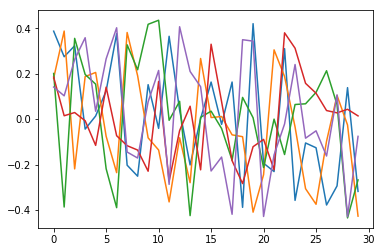

In [60]:
i=2
print cell_types[cell_idxs[-k:]]
cell_idx = cell_idxs[-k:][i]
print cell_types[cell_idx]
# plt.plot(W[cell_types[cell_idx]])
plt.plot(np.squeeze(W.values()).T)
# plt.plot(reduced_binned_spikes[-1,:])

In [4]:
D = np.load('movie_data.npz')
binned_spikes = D['binned_spikes']
stim_array = D['stim_array']


In [11]:
binned_spikes = np.expand_dims(np.loadtxt('binned_spikes_cell_2.txt',delimiter=','),0)
stim_array = np.expand_dims(np.loadtxt('binned_stim_cell_2.txt',delimiter=','),0)

In [22]:
np.savez('state_save',binned_spikes=binned_spikes, stim_array=stim_array, cell_types=cell_types)

Text(0,0.5,'training loss - unique parameters')

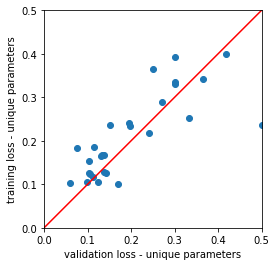

In [54]:
D = np.load('param_nonshared_run1.npz')
pts = [0,0.5]
plt.scatter(val_losses, losses)
plt.plot(pts,pts,'r')
plt.plot
plt.axis('square')
plt.xlim(pts)
plt.ylim(pts)
plt.xlabel('validation loss - unique parameters')
plt.ylabel('training loss - unique parameters')

In [18]:
print models[0].metrics_names

['loss']
